In [1]:
%gui wx
import sys
import os

#####################
# Import of utils.py functions
#####################
# Required to get utils.py and access its functions
notebook_dir = os.path.abspath("")
parent_dir = os.path.abspath(os.path.join(notebook_dir, '..'))
sys.path.append(parent_dir)
sys.path.append('.')
from utils import loadFSL, FSLeyesServer, mkdir_no_exist, interactive_MCQ

####################
# DIPY_HOME should be set prior to import of dipy to make sure all downloads point to the right folder
####################
os.environ["DIPY_HOME"] = "/data"


#############################
# Loading fsl and freesurfer within Neurodesk
# You can find the list of available other modules by clicking on the "Softwares" tab on the left
#############################
import lmod
await lmod.purge(force=True)
await lmod.load('fsl/6.0.7.4')
await lmod.load('freesurfer/7.4.1')
await lmod.list()

####################
# Setup FSL path
####################
loadFSL()

###################
# Load all relevant libraries for the lab
##################
import fsl.wrappers
from fsl.wrappers import fslmaths

import mne_nirs
import nilearn
from nilearn.datasets import fetch_development_fmri

import mne
import mne_nirs
import dipy
from dipy.data import fetch_bundles_2_subjects, read_bundles_2_subjects
import xml.etree.ElementTree as ET
import os.path as op
import nibabel as nib
import glob

import ants

import openneuro
from mne.datasets import sample
from mne_bids import BIDSPath, read_raw_bids, print_dir_tree, make_report


# Useful imports to define the direct download function below
import requests
import urllib.request
from tqdm import tqdm


# FSL function wrappers which we will call from python directly
from fsl.wrappers import fast, bet
from fsl.wrappers.misc import fslroi
from fsl.wrappers import flirt

# General purpose imports to handle paths, files etc
import glob
import pandas as pd
import numpy as np
import json
import subprocess

In [4]:
fsleyesDisplay = FSLeyesServer()
fsleyesDisplay.show()

08:47:32: Debug: Adding duplicate image handler for 'Windows bitmap file'
08:47:32: Debug: Adding duplicate animation handler for '1' type
08:47:32: Debug: Adding duplicate animation handler for '2' type
08:47:32: Debug: Adding duplicate image handler for 'Windows bitmap file'
08:47:32: Debug: Adding duplicate animation handler for '1' type
08:47:32: Debug: Adding duplicate animation handler for '2' type

(ipykernel_launcher.py:1762): Gtk-CRITICAL **: 08:47:32.900: gtk_window_resize: assertion 'height > 0' failed


Loading data 

In [3]:
fsleyesDisplay.load(op.expandvars('T1w.nii.gz'))

In [7]:
sample_path = "/data"
mkdir_no_exist(sample_path)
deriv_= op.join(sample_path, 'derivatives')

In [9]:
preproc_root = op.join(sample_path, 'derivatives','preprocessed_data')
mkdir_no_exist(preproc_root)

skull stripping with BET

In [6]:
def skull_stripped(sample_root, preproc_root, robust=False):
    """
    Perform skull stripping on a T1w anatomical image and save directly in preproc_root.
    
    Args:
        sample_root (str): Path to the directory containing the input T1w image.
        preproc_root (str): Path to save the skull-stripped outputs.
        robust (bool): Whether to use robust mode (-R) in BET.
    """
    anatomical_path = op.join(sample_root, 'T1w.nii.gz')
    betted_brain_path = op.join(preproc_root, 'T1w_stripped')
    os.system(f'bet {anatomical_path} {betted_brain_path} -m {"-R" if robust else ""}')
    print("Done with BET.")

In [7]:
skull_stripped(sample_path, preproc_root)

Done with BET.


In [8]:
resulting_mask_path = op.join(preproc_root, 'T1w_stripped_mask.nii.gz')

In [9]:
fsleyesDisplay.load(resulting_mask_path)

Setting Robust = TRUE 

In [10]:
skull_stripped(sample_path, preproc_root, robust=True)

Done with BET.


In [11]:
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(op.join(sample_path, 'T1w.nii.gz'))
fsleyesDisplay.load(resulting_mask_path)


(ipykernel_launcher.py:523): Gdk-WARNING **: 08:37:30.842: gdkdrawable-x11.c:952 drawable is not a pixmap or window
08:37:30: Debug: ClientToScreen cannot work when toplevel window is not shown
08:37:30: Debug: ClientToScreen cannot work when toplevel window is not shown

(ipykernel_launcher.py:523): Gdk-WARNING **: 08:37:30.844: gdkdrawable-x11.c:952 drawable is not a pixmap or window
08:37:30: Debug: ClientToScreen cannot work when toplevel window is not shown
08:37:30: Debug: ClientToScreen cannot work when toplevel window is not shown

(ipykernel_launcher.py:523): Gdk-WARNING **: 08:37:30.845: gdkdrawable-x11.c:952 drawable is not a pixmap or window
08:37:30: Debug: ClientToScreen cannot work when toplevel window is not shown
08:37:30: Debug: ClientToScreen cannot work when toplevel window is not shown

(ipykernel_launcher.py:523): Gdk-WARNING **: 08:37:30.846: gdkdrawable-x11.c:952 drawable is not a pixmap or window
08:37:30: Debug: ClientToScreen cannot work when toplevel window

Tissue segmentation 

In [12]:
anatomical_path = op.join(sample_path, 'T1w.nii.gz')
bet_path = op.join(preproc_root,'T1w_stripped.nii.gz') 

In [ ]:
fast_target = bet_path 
[os.remove(f) for f in glob.glob(op.join(preproc_root, '*fast*'))] 
segmentation_path = op.join(preproc_root, 'T1w_fast')
fast(imgs=[fast_target], out=segmentation_path, n_classes=3)

In [ ]:
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(bet_path)
fsleyesDisplay.load(glob.glob(op.join(preproc_root, '*pve_0*'))[0])
fsleyesDisplay.load(glob.glob(op.join(preproc_root, '*pve_1*'))[0])
fsleyesDisplay.load(glob.glob(op.join(preproc_root, '*pve_2*'))[0])
fsleyesDisplay.displayCtx.getOpts(fsleyesDisplay.overlayList[1]).cmap = 'Red'
fsleyesDisplay.displayCtx.getOpts(fsleyesDisplay.overlayList[2]).cmap = 'Green'
fsleyesDisplay.displayCtx.getOpts(fsleyesDisplay.overlayList[3]).cmap = 'Blue'

Concatenation and variance correction

In [14]:
import nibabel as nib
import numpy as np
from nilearn.image import concat_imgs, new_img_like

In [15]:
# --- Load MRI runs ---
run1 = nib.load("tfMRI_MOTOR_LR.nii")
run2 = nib.load("tfMRI_MOTOR_RL.nii")

In [16]:
# --- Convert to numpy arrays ---
data1 = run1.get_fdata()
data2 = run2.get_fdata()

In [17]:
# --- Rescale variance of each run to 1 ---
var1 = np.var(data1)
var2 = np.var(data2)

data1_scaled = data1 / np.sqrt(var1)
data2_scaled = data2 / np.sqrt(var2)

In [18]:
# --- Create new NIfTI images ---
img1_scaled = new_img_like(run1, data1_scaled)
img2_scaled = new_img_like(run2, data2_scaled)

In [19]:
# --- Concatenate the two runs ---
concatenated_img = concat_imgs([img1_scaled, img2_scaled])

In [22]:
# --- Save the concatenated image ---
concatenated_img.to_filename("sub-101410_task-motor_concat_bold.nii.gz")

Motion correction

In [2]:
from fsl.wrappers import mcflirt

In [ ]:
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(op.expandvars('tfMRI_MOTOR_LR.nii'))

In [10]:
functional_data_path = op.join(sample_path,'tfMRI_MOTOR_LR.nii')
path_moco_data = op.join(preproc_root,'fMRI_MOTOR_LR_moco.nii.gz') 

In [ ]:
mcflirt(infile=functional_data_path,
        o=path_moco_data,
        plots=True,
        report=True,
        dof=6,
        mats=True)

In [12]:
def load_mot_params_fsl_6_dof(path):
    return pd.read_csv(path, sep='  ', header=None, 
            engine='python', names=['Rotation x', 'Rotation y', 'Rotation z','Translation x', 'Translation y', 'Translation z'])

In [13]:
mot_params = load_mot_params_fsl_6_dof(op.join(preproc_root, 'fMRI_MOTOR_LR_moco.nii.gz.par'))
mot_params

,Rotation x,Rotation y,Rotation z,Translation x,Translation y,Translation z
0,0.001223,-0.000288,0.000072,-0.093125,0.142566,-0.093905
1,0.001820,0.000269,0.000125,0.092541,0.137253,0.052417
2,0.001820,-0.000288,0.000032,-0.093116,-0.058502,0.077914
3,0.001820,-0.000288,0.000067,-0.093109,-0.074998,0.089876
4,0.001419,-0.000288,0.000062,-0.089408,0.123184,0.064979
...,...,...,...,...,...,...
279,0.000141,-0.000887,-0.000020,-0.066619,-0.060364,-0.045326
280,0.000194,-0.001056,-0.000089,-0.067133,-0.061685,-0.060010
281,0.000092,-0.000713,-0.000111,-0.070045,-0.066122,-0.055728
282,0.000202,-0.000657,-0.000103,-0.074327,-0.066125,-0.061872


In [14]:
def compute_FD_power(mot_params):
    framewise_diff = mot_params.diff().iloc[1:]

    rot_params = framewise_diff[['Rotation x', 'Rotation y', 'Rotation z']]
    # Estimating displacement on a 50mm radius sphere
    # To know this one, we can remember the definition of the radian!
    # Indeed, let the radian be theta, the arc length be s and the radius be r.
    # Then theta = s / r
    # We want to determine here s, for a sphere of 50mm radius and knowing theta. Easy enough!
    
    # Another way to think about it is through the line integral along the circle.
    # Integrating from 0 to theta with radius 50 will give you, unsurprisingly, r0 theta.
    converted_rots = rot_params*50
    trans_params = framewise_diff[['Translation x', 'Translation y', 'Translation z']]
    fd = converted_rots.abs().sum(axis=1) + trans_params.abs().sum(axis=1)
    return fd

fd = compute_FD_power(mot_params).to_numpy()

In [15]:
threshold = np.quantile(fd,0.75) + 1.5*(np.quantile(fd,0.75) - np.quantile(fd,0.25))

In [16]:
import matplotlib.pyplot as plt

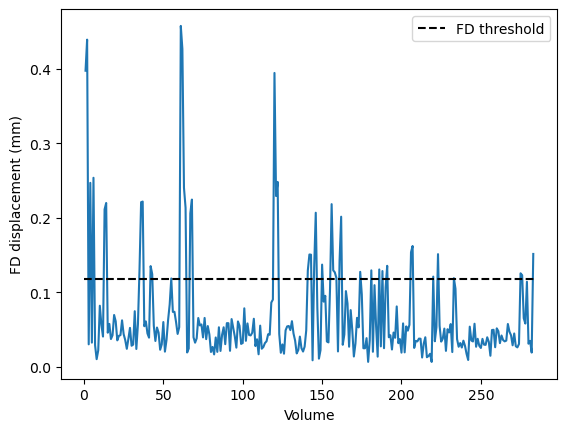

In [17]:
#%matplotlib inline
plt.plot(list(range(1, fd.size+1)), fd)
plt.xlabel('Volume')
plt.ylabel('FD displacement (mm)')
plt.hlines(threshold, 0, 284,colors='black', linestyles='dashed', label='FD threshold')
plt.legend()
plt.show()

Gaussian smoothing

In [18]:
input_path = op.join(preproc_root, 'fMRI_MOTOR_LR_moco.nii.gz')

In [19]:
cmd = 'fslmaths {} -s {} {}_smoothed-6mm'.format(input_path, 6/2.3548, input_path)
subprocess.run(['fslmaths',input_path, '-s', str(6/2.3548), '{}_smoothed-6mm'.format(input_path)])

CompletedProcess(args=['fslmaths', '/data/derivatives/preprocessed_data/fMRI_MOTOR_LR_moco.nii.gz', '-s', '2.547987090198743', '/data/derivatives/preprocessed_data/fMRI_MOTOR_LR_moco.nii.gz_smoothed-6mm'], returncode=0)

In [21]:
fsleyesDisplay.load(input_path + '_smoothed-6mm')